# Introduction

PMA is an OCaml library for Probabilistic Matrix Approximation. It implements the algorithms from the paper [Finding Structure with Randomness: Probabilistic Algorithms for Constructing Approximate Matrix Decompositions](https://doi.org/10.1137/090771806). Some algorithms still need to be implemented or optimized, and the code still needs to be fully tested. 

The documentation can be generated with `dune build @doc-private` and can then be found in 
`_build/default/_doc/_html`.

In [ ]:
#use "topfind"
#require "owl,owl-top,owl-plplot,jupyter.notebook"

#use_output "dune top" ;;

Jupyter_notebook.clear_output ()

The main feature of PMA is modularity : although it is built with the goal to be used along with [the Owl library](https://ocaml.xyz/), it can in practice be used with any linear algebra library by providing an interface module of signature `Pma.Matrix.Matrix` to the functor `Pma.Fact.Make`.

In [126]:
#show Pma.Matrix.Matrix
#show Pma.Fact.Make

module type Matrix =
  sig
    type elt
    type mat
    type complex_mat
    val to_float : elt -> float
    val cast : mat -> complex_mat
    val shape : mat -> int * int
    val zeros : int -> int -> mat
    val eye : int -> mat
    val gaussian : ?mu:elt -> ?sigma:elt -> int -> int -> mat
    val sub : mat -> mat -> mat
    val dot : mat -> mat -> mat
    val dot_complex : complex_mat -> complex_mat -> complex_mat
    val mul : mat -> mat -> mat
    val div_scalar : mat -> elt -> mat
    val triangular_solve : mat -> mat -> mat
    val max' : mat -> elt
    val l2norm : ?axis:int -> ?keep_dims:bool -> mat -> mat
    val l2norm' : mat -> elt
    val get_slice : int list list -> mat -> mat
    val transpose : mat -> mat
    val ctranspose : mat -> mat
    val concat_horizontal : mat -> mat -> mat
    val qr : mat -> mat * mat
    val svd : mat -> mat * mat * mat
    val eig : mat -> complex_mat * complex_mat
    val chol : mat -> mat
  end
module Make = Pma.Fact.Make
module Make : Pm

Such an implementation is already provided for the submodules of `Owl.Dense.Matrix`.

In [ ]:
module RNdarray = Owl.Dense.Ndarray.D
module RMat = Owl.Dense.Matrix.D
module RLinalg = Owl.Linalg.D ;;
module RFact = Pma.Fact.D
module RFactTest = Pma.Test.D

module C = Complex
module CMat = Owl.Dense.Matrix.Z
module CFact = Pma.Fact.Z
module Fft = Owl.Fft.D

module Ndarray = Owl.Dense.Ndarray.Generic ;;
module Maths = Owl.Maths
module Plot = Owl_plplot.Plot

# Content of the library

Let us now review the content of a module of signature `Pma.Fact.Fact`. Throughout this review, we will work with 64-bit complex matrices implemented in the `Owl.Dense.Matrix.Z` module.

In [7]:
#show Pma.Fact.Fact

module type Fact =
  sig
    type elt
    type mat
    type complex_mat
    type range_sampler = mat -> int -> mat
    val gaussian_range_sampler : range_sampler
    type range_finder = mat -> mat
    val randomized_range_finder :
      ?sampler:range_sampler -> int -> range_finder
    val adaptive_randomized_range_finder :
      ?sampler:range_sampler -> ?r:int -> float -> range_finder
    val randomized_subspace_iteration :
      ?sampler:range_sampler -> int -> int -> range_finder
    val adaptive_randomized_subspace_iteration :
      ?sampler:range_sampler -> ?r:int -> int -> float -> range_finder
    val direct_svd : mat -> mat -> mat * mat * mat
    val direct_eig : mat -> mat -> complex_mat * complex_mat
    val nystrom_eig : mat -> mat -> mat * mat
    val approximate : range_finder -> (mat -> mat -> 'a) -> mat -> 'a
  end


Three types of functions are defined : _range samplers_, _range finders_ and _postprocessors_.

## Range samplers

Range samplers are functions that sample random vectors in the range of a matrix. The default range sampler uses gaussian sampling.

In [8]:
#show CFact.range_sampler ;;
#show CFact.gaussian_range_sampler ;;

type nonrec range_sampler = CFact.mat -> int -> CFact.mat
val gaussian_range_sampler : CFact.range_sampler


In [9]:
let a = CMat.ones 3 3 in
let range_sampler = CFact.gaussian_range_sampler a in
range_sampler 4

- : CFact.mat =

             C0              C1            C2            C3 
R0 (1.1803, 0i) (-0.519549, 0i) (1.76975, 0i) (2.45171, 0i) 
R1 (1.1803, 0i) (-0.519549, 0i) (1.76975, 0i) (2.45171, 0i) 
R2 (1.1803, 0i) (-0.519549, 0i) (1.76975, 0i) (2.45171, 0i) 



Range samplers are easy to add. As an example, we implement the Fourier range sampler (Algorithm 4.5), not implemented by default in PMA because the Hadamard transform (necessary for real matrices) is not implemented in Owl.

The following version only supports sampling at most $n$ vectors from an $n \times m$ matrix, but this is not a problem for matrices of rank $r \ll n$ as they usually only require the sampling of around $r$ vectors.

When implementing a range sampler, it is important to keep in mind that, during the execution of a range finder, the sampler is instantiated once for a given matrix and the resulting function may then be called several times.

In [128]:
let fourier_range_sampler (a : CMat.mat) : int -> CMat.mat =
    let _, n = CMat.shape a in
    
    (* d ~ U(unit circle) *)
    let d : CMat.mat = CMat.polar (RMat.ones 1 n) (RMat.uniform ~b:(2. *. Float.pi) 1 n) in
    
    let samples = CMat.shuffle_rows (CMat.mul a d) in
    let i = ref 0 in
    let sampler k =
        let samples_chosen = try 
            CMat.get_slice [ [] ; [!i ; !i+k-1] ] samples 
            with _ -> failwith "too many samples required" in
        i := !i + k ;
        CMat.mul_scalar (Fft.fft ~axis:1 samples_chosen) C.{re = Stdlib.sqrt (float n /. float k) ; im = 0.} in
    sampler

val fourier_range_sampler : CMat.mat -> int -> CMat.mat = <fun>


In [11]:
let a = CMat.ones 3 3 in
let range_sampler = fourier_range_sampler a in
range_sampler 3

- : CMat.mat =

                        C0                     C1                    C2 
R0 (0.695991, -0.0327037i) (0.657222, 0.0672092i) (-0.408123, 2.81274i) 
R1 (0.695991, -0.0327037i) (0.657222, 0.0672092i) (-0.408123, 2.81274i) 
R2 (0.695991, -0.0327037i) (0.657222, 0.0672092i) (-0.408123, 2.81274i) 



## Range finders

Range finders are functions that find an orthogonal family that generates the range of a matrix.

They do so by first finding a generating family of the range of the matrix using a range sampler (that can be specified as an optional parameter) and then making that family orthogonal using orthogonalization procedures such as [the Gram-Schmidt process](https://en.wikipedia.org/wiki/Gram%E2%80%93Schmidt_process).

Let us for example find a basis for the range of a simple matrix whose coefficients are all ones. We know that its rank is $1$, and thus we can ask our range finder to find a family of size $1$.

Note that for matrices with bigger ranks $r$, because of the probabilistic nature of the algorithms, you should ask the range finder to find a family of size $l = k + p$ with $p \sim 5$ or $p \sim 10$ and $k$ the expected size of the family of vectors. Of course, when $k < r$ one may only expect to get an approximation of the range of the matrix.

In [12]:
#show CFact.randomized_range_finder ;;

val randomized_range_finder :
  ?sampler:CFact.range_sampler -> int -> CFact.range_finder


In [13]:
let a = CMat.ones 3 3 in 
let range_finder = CFact.randomized_range_finder 1 in
range_finder a

- : CFact.mat =

               C0 
R0 (-0.57735, 0i) 
R1 (-0.57735, 0i) 
R2 (-0.57735, 0i) 



What if the rank of the matrix is unknown ? Each range finder has an _adaptive_ version : instead of looking for a generating family of fixed size, it grows the family until sufficient precision $\epsilon$ has been reached. If $A$ is the $m \times n$ matrix whose range we are looking for, the resulting orthogonal family $Q$ verifies 
$$|| (I - QQ^*)A || \le \epsilon$$
with probability at least $1 - \min(m,n)10^{-r}$, where $r$ is an optional parameter that defaults to $10$.

In [14]:
#show CFact.adaptive_randomized_range_finder ;;

val adaptive_randomized_range_finder :
  ?sampler:CFact.range_sampler -> ?r:int -> float -> CFact.range_finder


In [129]:
let a = CMat.ones 3 3 in
let epsilon = 0.01 in
let range_finder = CFact.adaptive_randomized_range_finder epsilon in
let q = range_finder a in
assert ((CMat.sub a (CMat.dot q @@ CMat.dot (CMat.ctranspose q) @@ a) |> CMat.l2norm').re <= epsilon) ;
q

- : CFact.mat =

              C0 
R0 (0.57735, 0i) 
R1 (0.57735, 0i) 
R2 (0.57735, 0i) 



`randomized_range_finder` is the most basic kind of range finder. For matrices whose singular values decay slowly, its performance can be improved by finding the range of powers of the matrix (effectively making the singular values decay faster). This procedure is called _subspace iteration_. In practice, it only requires the additional specification of the power and it can then be used just as the basic range finder.

In [16]:
#show CFact.randomized_subspace_iteration
#show CFact.adaptive_randomized_subspace_iteration

val randomized_subspace_iteration :
  ?sampler:CFact.range_sampler -> int -> int -> CFact.range_finder
val adaptive_randomized_subspace_iteration :
  ?sampler:CFact.range_sampler ->
  ?r:int -> int -> float -> CFact.range_finder


## Postprocessors

Postprocessors use the range of a matrix to factorize it. In practice it is only provided with an approximation of the range so the resulting factorization is approximative.

Currently three kinds of factorization are provided : singular value decomposition, eigenvalue decomposition and eigenvalue decomposition using the Nyström mathod (which is more accurate but only works with positive semidefinite matrices).

In [17]:
#show CFact.direct_svd
#show CFact.direct_eig
#show CFact.nystrom_eig

val direct_svd : CFact.mat -> CFact.mat -> CFact.mat * CFact.mat * CFact.mat
val direct_eig :
  CFact.mat -> CFact.mat -> CFact.complex_mat * CFact.complex_mat
val nystrom_eig : CFact.mat -> CFact.mat -> CFact.mat * CFact.mat


Here, since our target matrix is positive semidefinite, we use the Nyström method.

In [18]:
let a = CMat.ones 3 3 in
let q = CFact.randomized_range_finder 1 a in
let u, lambda = CFact.nystrom_eig a q in
u, lambda, CMat.dot u @@ CMat.mul lambda @@ CMat.ctranspose u

- : CFact.mat * CFact.mat * CMat.mat =
(
               C0 
R0 (-0.57735, 0i) 
R1 (-0.57735, 0i) 
R2 (-0.57735, 0i) 
,
 
        C0 
R0 (3, 0i) 
,
 
        C0      C1      C2 
R0 (1, 0i) (1, 0i) (1, 0i) 
R1 (1, 0i) (1, 0i) (1, 0i) 
R2 (1, 0i) (1, 0i) (1, 0i) 
)


In practice, there is no need to use the postprocessors directly : they may be passed as an argument to the `approximate`
function.

In [19]:
#show CFact.approximate

val approximate :
  CFact.range_finder -> (CFact.mat -> CFact.mat -> 'a) -> CFact.mat -> 'a


In [20]:
let a = CMat.ones 3 3 in
CFact.approximate (CFact.randomized_range_finder 1) CFact.nystrom_eig a

- : CFact.mat * CFact.mat =
(
               C0 
R0 (-0.57735, 0i) 
R1 (-0.57735, 0i) 
R2 (-0.57735, 0i) 
,
 
        C0 
R0 (3, 0i) 
)


# Checking correctness

Let us now check that the claims that the output of the algorithms verify some conditions with high probability are true. To do so we carry out a [binomial test](https://en.wikipedia.org/wiki/Binomial_test).

We will be using functions imported from the `Pma.Test` submodules.

In [21]:
#show Pma.Test.Test

module type Test =
  sig
    type elt
    type mat
    type range_finder
    val error_factorization : mat list -> mat -> elt
    val error_range_finder : range_finder -> mat -> elt
    val test_error : elt -> float -> bool
    val test_adaptive_range_finder :
      (float -> range_finder) -> float -> mat -> bool
  end


## Adaptive randomized range finder

We first study the case of the adaptive algorithm : we will check that 
$$|| (I - QQ^*)A || \le \epsilon$$
with probability at least $1 - \min(m,n)10^{-r}$. We will do so for both fixed and random $A$.

We now use real 64-bit matrices.

In [ ]:
type int_ndarray = (int, Bigarray.int16_unsigned_elt) Ndarray.t ;;
let int_ndarray_kind = Bigarray.Int16_unsigned ;;

In [135]:
let int_range 
    ?start:(start=0) 
    ?step:(step=1) 
    (n : int) 
    : int_ndarray = 
    Ndarray.init int_ndarray_kind [|n-start|] (fun i -> start + step * i)

val int_range : ?start:int -> ?step:int -> int -> int_ndarray = <fun>


In [136]:
let count_adaptive_range_finder_failures
    ?show_steps:(show_steps=false)
    (rs : int_ndarray)
    (epsilons : RNdarray.arr) 
    (iters : int) 
    (gen_mat : int -> float -> int -> RMat.mat)
    : int_ndarray =
    let shape = Array.concat [Ndarray.shape rs ; Ndarray.shape epsilons] in
    let failures_range_finder = Ndarray.create int_ndarray_kind shape 0 in
    Ndarray.iteri_nd (fun r_index r -> 
        RNdarray.iteri_nd (fun eps_index eps -> 
            for k = 1 to iters do
                if show_steps then (
                    Jupyter_notebook.printf "r = %d, eps = %f, iter = %d / %d@." r eps k iters ;
                    ignore (Jupyter_notebook.display_formatter "text/html") ;
                ) ;
                let a = gen_mat r eps k in
                if not (RFactTest.test_adaptive_range_finder (RFact.adaptive_randomized_range_finder ~r:r) eps a) then
                    let index = Array.concat [r_index ; eps_index] in 
                    Ndarray.set failures_range_finder index (Ndarray.get failures_range_finder index + 1)
            done)
        epsilons)
    rs ;
    failures_range_finder   
    


val count_adaptive_range_finder_failures :
  ?show_steps:bool ->
  int_ndarray ->
  RNdarray.arr -> int -> (int -> float -> int -> RMat.mat) -> int_ndarray =
  <fun>


## Approximating a Laplacian

We first start by approximating a Laplacian in dimension $n = 100$. Laplacians are matrices that correspond to discrete second-order derivatives ; as such, they are widely used as soon as differential equations come into play.

In [ ]:
let n = 100

In [139]:
let laplacian = 
    let laplacian_upper = RMat.bidiagonal 
                            (RMat.scalar_mul 2. (RMat.ones 1 n))
                            (RMat.scalar_mul (-1.) (RMat.ones 1 (n-1))) in
    RMat.set laplacian_upper 0 (n-1) (-1.) ;
    RMat.symmetric laplacian_upper

val laplacian : RMat.mat =
  
     C0  C1  C2  C3  C4     C95 C96 C97 C98 C99 
 R0   2  -1   0   0   0 ...   0   0   0   0  -1 
 R1  -1   2  -1   0   0 ...   0   0   0   0   0 
 R2   0  -1   2  -1   0 ...   0   0   0   0   0 
 R3   0   0  -1   2  -1 ...   0   0   0   0   0 
 R4   0   0   0  -1   2 ...   0   0   0   0   0 
    ... ... ... ... ... ... ... ... ... ... ... 
R95   0   0   0   0   0 ...   2  -1   0   0   0 
R96   0   0   0   0   0 ...  -1   2  -1   0   0 
R97   0   0   0   0   0 ...   0  -1   2  -1   0 
R98   0   0   0   0   0 ...   0   0  -1   2  -1 
R99  -1   0   0   0   0 ...   0   0   0  -1   2 



We chose to compute $100$ approximations for each set of parameters of the adaptive randomized range finders. Here we constrain $r$ to range from $2$ to $5$ and $\epsilon$ from $0.0001$ to $1$. 

It doesn't make sense to go with greater values of $r$ since the probability of failure should be lower than $n10^{-r}$ which is below $1/1000$ for $r \ge 5$, thus making it unlikely to have any failure on a sample size of $100$.

In [25]:
let epsilons = (RNdarray.logspace ~base:10. 0. (-4.) 5) ;;
let rs = (int_range ~start:2 6) ;;

let failures = count_adaptive_range_finder_failures
    ~show_steps:true
    rs
    epsilons
    100
    (fun _ _ _ -> laplacian)
in Jupyter_notebook.clear_output () ;
failures

- : int_ndarray =

   C0 C1 C2 C3 C4 
R0  0  0  0  0  0 
R1  0  0  0  0  0 
R2  0  0  0  0  0 
R3  0  0  0  0  0 



We find that the procedure never failed, so the statistical test to carry out is very simple : the $p$-value for the hypothesis that, for a fixed $r$, the probability of failure is $\pi \in [0,1]$ is $2 * (1-\pi)^{500}$ (we carried out $100$ experiments for each value of $\epsilon$). In particular, we can reject (for the chosen parameters) the hypothesis that the probability of failure is greater than $1-\mathrm{min}(n,m)10^{-r}$ with confidence $1 - 2 * (1-\pi)^{500}$.

In [27]:
let new_get_color_fun () : unit -> Plot.spec = 
    let cycle = Array.map (fun (r,g,b) -> Plot.RGB (r,g,b)) 
        [|(31,119,180) ; (255,127,14) ; (44,160,44) ; (214,39,40) ; (148,103,189) ; (140,86,75) ; (227,119,194) ; (127,127,127) ; (188,189,34) ; (23,190,207)|] in
    let i = ref 0 in
    let n = Array.length cycle in
    (fun () -> let color = cycle.(!i mod n) in i := !i + 1 ; color) 

val new_get_color_fun : unit -> unit -> Plot.spec = <fun>


In [28]:
let display_plot 
    ?path:(path="/tmp/owl.png")
    (h : Plot.handle) 
    : Jupyter_notebook.display_id =
    
    Plot.output h ;
    
    let ic = open_in_bin path in
    let n = in_channel_length ic in
    let data = really_input_string ic n in
    close_in ic ;
    Jupyter_notebook.display ~base64:true "image/png" data

val display_plot : ?path:string -> Plot.handle -> Jupyter_notebook.display_id =
  <fun>


In [ ]:
let h = Plot.create "/tmp/owl.png" ;;

Plot.set_yrange h 0. 1. ;
let xs = RNdarray.logspace ~base:10. (-5.) 0. 100 in
let pvalues = RNdarray.map (fun x -> min 1. (2. *. (1. -. x) ** 500.)) xs in
Plot.semilogx ~h ~spec:[RGB (255,0,0) ; LineWidth 3.] ~x:xs pvalues ;

Ndarray.iter (fun r ->
    let log_probability = 2. -. (float r) in
    Plot.draw_line ~h ~spec:[LineStyle 3 ; LineWidth 3.] log_probability 0. log_probability 1. ;
    let legend = Format.sprintf "r = %d" r in
    Plot.text ~h (log_probability -. 0.2) 0.5 ~dy:1. legend ;
) rs ;

Plot.set_xlabel h "supposed probability of failure" ;
Plot.set_ylabel h "p-value" ;
Plot.set_title h "p-values for an hypothesis on the probability of failure" ;

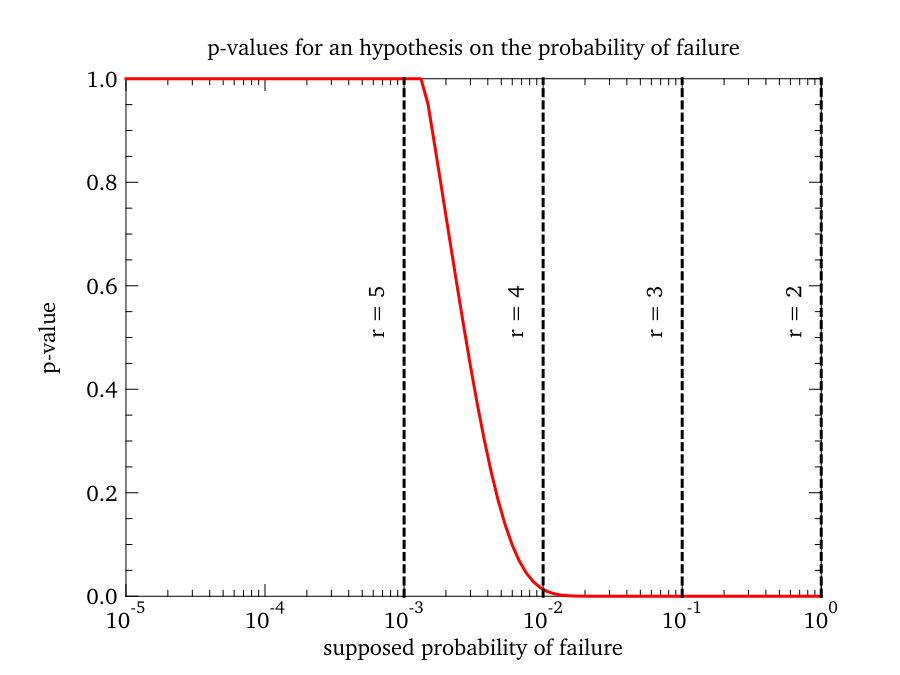

- : Jupyter_notebook.display_id = <abstr>


In [115]:
display_plot h

As expected, we confirmed with high confidence that the probability of failure is indeed below the theoretical bound for $r = 2,3,4$. For $r = 5$ more experiments need to be carried out to confirm the hypothesis (this is expected as the theoretical bound is $1/1000$).

## Approximating random matrices

We can do the same test but with random matrices. To ensure they don't have full rank, we take them of size $m \times n$ where $m = 100$ and $n$ is chosen randomly between $10$ and $90$.

In [56]:
let random_mat _ _ _ = 
    let m = 100 in
    let n = 10 + Random.int 80 in
    RMat.gaussian m n 

val random_mat : 'a -> 'b -> 'c -> RMat.mat = <fun>


In [57]:
let failures = count_adaptive_range_finder_failures
    ~show_steps:true
    (int_range ~start:2 6)
    (RNdarray.logspace ~base:10. 0. (-4.) 5)
    100
    random_mat
in Jupyter_notebook.clear_output () ;
failures

- : int_ndarray =

   C0 C1 C2 C3 C4 
R0  0  0  0  0  0 
R1  0  0  0  0  0 
R2  0  0  0  0  0 
R3  0  0  0  0  0 



Once again, we find that the procedure never failed, so we've confirmed empirically that 
$$|| (I - QQ^*)A || \le \epsilon$$
with probability at least $1 - \min(m,n)10^{-r}$ for random matrices and $r = 2,3,4$, and that more experiments need to be carried out for $r = 5$.

# Computing the average error

We now set out to compute an empirical average for the error $|| (I - QQ^*)A ||$. Once again, we will do so with both fixed and random $A$.

In [117]:
let errors_range_finder
    ?show_steps:(show_steps=false)
    (range_finder : int -> RFact.range_finder)
    (ls : int_ndarray)
    (sample_size : int)
    (gen_mat : int -> int -> RMat.mat)
    : RMat.mat =
    let ls = Ndarray.flatten ls in 
    RMat.init_2d (Ndarray.shape ls).(0) sample_size (fun i iter -> 
        let l = Ndarray.get ls [|i|] in
        if show_steps then (
            Jupyter_notebook.printf "iter = %d / %d, l = %d" (iter + 1) sample_size l ;
            ignore (Jupyter_notebook.display_formatter "text/html") ;
        ) ; 
        let a = gen_mat l iter in
        RFactTest.error_range_finder (range_finder l) a
    )

val errors_range_finder :
  ?show_steps:bool ->
  (int -> RFact.range_finder) ->
  int_ndarray -> int -> (int -> int -> RMat.mat) -> RMat.mat = <fun>


We will compare these empirical errors to the optimal error we can get when approximating a matrix by another fixed-rank one, which can be achieved by carrying out a principal component analysis (PCA).

In [118]:
let errors_pca (a : RMat.mat) : RMat.mat =
    let u, _, v = RLinalg.svd a in
    let _, n = RMat.shape a in
    RMat.init 1 n (fun i ->
        let new_u = RMat.get_slice [[] ; [0;i]] u in
        let new_v = RMat.get_slice [[0;i] ; []] v in
        let q = RMat.dot new_u new_v in
        RFactTest.error_range_finder (fun _ -> q) a
    )

val errors_pca : RMat.mat -> RMat.mat = <fun>


Finally we will also compare these average errors to the theoretical bound given in the paper.

In [119]:
let errors_theory (a : RMat.mat) : RMat.mat =
    let _, eigvals, _ = RLinalg.svd a in
    let _, n = RMat.shape a in
    RMat.init 1 n (fun i ->
        let l = i + 1 in
        if l <= 4 then
            nan
        else if l < n then
            let ps = int_range ~start:2 (l-2) in
            RMat.init 1 (l-4) (fun i ->
                let p = Ndarray.get ps [|i|] in
                let k = l - p in
                sqrt (1. +. float k /. (float p -. 1.)) *. RMat.l2norm' (RMat.get_slice [[];[k+1;n-1]] eigvals)
            ) |> RMat.min'
        else 
            0.
    )

val errors_theory : RMat.mat -> RMat.mat = <fun>


In [120]:
let compute_average_errors 
    ?show_steps:(show_steps=false)
    (a : RMat.mat)
    (sample_size : int)
    (subspace_iterations : int_ndarray) 
    : RMat.mat * RMat.mat * RMat.mat = 
    
    let m, n = RMat.shape a in
    let dim = max m n in
    
    let ls = int_range ~start:1 (dim+1) in
    
    let errors_range_finder_a = RNdarray.empty [|(Ndarray.shape subspace_iterations).(0) ; dim ; sample_size|] in
    Ndarray.iteri (fun i power ->
        if show_steps then (
            Jupyter_notebook.printf "subspace iteration = %d" power ;
            ignore (Jupyter_notebook.display_formatter "text/html") ;
        ) ;
        RNdarray.set_slice 
            [[i] ; [] ; []]
            errors_range_finder_a
            (RNdarray.reshape 
                (errors_range_finder 
                    ~show_steps:false
                    (RFact.randomized_subspace_iteration power)
                    ls
                    sample_size
                    (fun _ _ -> a))
                [|1 ; dim ; sample_size|])
    ) subspace_iterations ;
    
    if show_steps then
        Jupyter_notebook.clear_output () ;
        
    let errors_pca_a = errors_pca a in
    let errors_theory_a = errors_theory a in
    
    errors_range_finder_a, errors_pca_a, errors_theory_a

val compute_average_errors :
  ?show_steps:bool ->
  RMat.mat -> int -> int_ndarray -> RMat.mat * RMat.mat * RMat.mat = <fun>


In [121]:
let plot_errors 
    ?path:(path="/tmp/owl.png")
    (subspace_iterations : int_ndarray)
    (errors_range_finder, errors_pca, errors_theory : RNdarray.arr * RMat.mat * RMat.mat)
    : Plot.handle =
    
    let _, dim = RMat.shape errors_pca in
    
    let ls = RMat.sequential ~a:1. dim 1 in
    let get_color = new_get_color_fun () in
    let names = Ndarray.to_array subspace_iterations |> Array.map (fun power -> Format.sprintf "%d iteration%s" power (if power >= 2 then "s" else "")) in
    let h = Plot.create path in

    Ndarray.iteri (fun i _ ->
        let errors = RNdarray.get_slice [[i] ; [] ; []] errors_range_finder in
        (* Plot.scatter ~h (RMat.flatten @@ RMat.mul (RMat.ones 1 100) @@ ls) (RNdarray.flatten errors) ; *)
        let average_errors = RNdarray.mean ~axis:2 errors in 
        Plot.plot ~h ~spec:[get_color () ; LineStyle 1 ; LineWidth 3.] ls average_errors ;
    ) subspace_iterations ;
    Plot.plot ~h ~spec:[LineStyle 3 ; LineWidth 3.] ls errors_pca ;
    Plot.plot ~h ~spec:[LineStyle 2] ls errors_theory ;

    Plot.set_xlabel h "rank of the approximation" ;
    Plot.set_ylabel h "average error" ;
    Plot.legend_on h (Array.concat [names ; [|"PCA";"theoretical bound"|]]) ;

    h

val plot_errors :
  ?path:string ->
  int_ndarray -> RNdarray.arr * RMat.mat * RMat.mat -> Plot.handle = <fun>


## Approximating a Laplacian

In [ ]:
let subspace_iterations = int_range 5 ;;

Jupyter_notebook.clear_output () ;;

let errors_laplacian, 
    errors_pca_laplacian, 
    errors_theory_laplacian = compute_average_errors 
                                ~show_steps:true 
                                laplacian
                                100
                                subspace_iterations

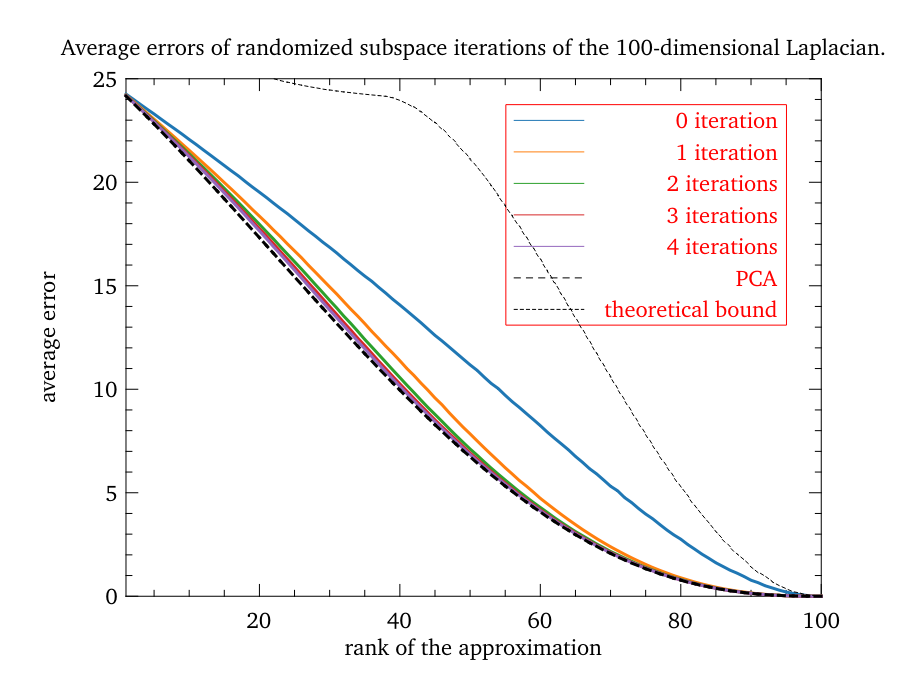

- : Jupyter_notebook.display_id = <abstr>


In [123]:
let h = plot_errors 
            subspace_iterations
            (errors_laplacian, errors_pca_laplacian, errors_theory_laplacian)
            
in 
Plot.set_yrange h 0. 25. ; 
Plot.set_title h "Average errors of randomized subspace iterations of the 100-dimensional Laplacian." ;

display_plot h

Here we can see how the randomized subspace iteration method can be used to decrease the influence of the lowest singular values on the output : the randomized range finder (the randomized subspace iteration with $0$ iterations) is not really precise (although already way better than expected in theory, especially for small ranks), as it is quite far from the optimal error given by the principal component analysis (PCA), but only a few iterations are needed to get significantly closer to the optimal possible error.

## Approximating a random matrix

In [ ]:
let random_mat = RMat.gaussian 100 100 ;;

Jupyter_notebook.clear_output () ;;

let errors_random, 
    errors_pca_random, 
    errors_theory_random = compute_average_errors 
                                ~show_steps:true 
                                random_mat
                                100
                                subspace_iterations

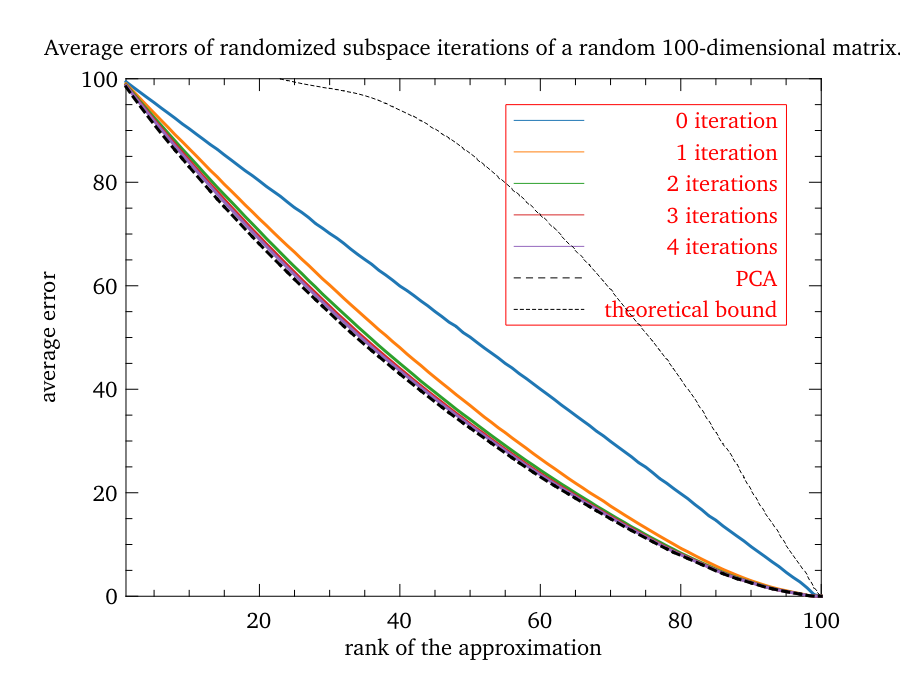

- : Jupyter_notebook.display_id = <abstr>


In [125]:
let h = plot_errors 
            subspace_iterations
            (errors_random, errors_pca_random, errors_theory_random)
            
in 
Plot.set_title h "Average errors of randomized subspace iterations of a random 100-dimensional matrix." ;
Plot.set_yrange h 0. 100. ; 
display_plot h

Doing the same but with a random matrix, we reach the same conclusions as with the Laplacian.